# Libs

In [1]:
# Работа с данными
import numpy as np
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt

# Улучшение модели
from sklearn.model_selection import train_test_split

# Метрики
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Torch
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchsummary import summary

In [2]:
# Остальное
from IPython.display import clear_output
from collections import defaultdict
from PIL import Image
from tqdm import tqdm
import warnings, os, random
from copy import deepcopy

warnings.filterwarnings('ignore')

# Code

In [3]:
print(torch.cuda.get_device_name()) # СИГМА

NVIDIA GeForce RTX 4060 Laptop GPU


## Полезные функции

In [4]:
def train(model, data_loader, optimizer, loss_fn):
    model = model.cuda()
    model.train()

    total_loss = 0
    total_correct = 0

    for x, y in tqdm(data_loader):
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        loss.backward()

        total_loss += loss.item()
 
        total_correct += (output.argmax(dim=1) == y).sum().item()

        optimizer.step()

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)


@torch.inference_mode()
def evaluate(model, data_loader, loss_fn):
    model = model.cuda()
    model.eval()

    total_loss = 0
    total_correct = 0

    for x, y in tqdm(data_loader):
        x, y = x.cuda(), y.cuda()
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        total_correct += (output.argmax(dim=1) == y).sum().item()

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)

def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()

    plt.show()

In [5]:
def fit(model, train_loader, valid_loader, optimizer, loss_fn, num_epochs, title='Model'):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    best_valid_accuracy = 0.0  # Переменная для отслеживания наилучшей точности
    best_model = None  # Переменная для сохранения модели с наилучшей точностью

    def epoch(count):
        nonlocal best_valid_accuracy, best_model

        train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn)
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        print(f"Epoch: {count}")
        print(f"Accuracy: {valid_accuracy:.4f}")

        if valid_accuracy > best_valid_accuracy:
            best_valid_accuracy = valid_accuracy
            best_model = deepcopy(model)  # Сохраняем текущее состояние модели

    epoch(1)

    for i in range(2, num_epochs + 1):
        epoch(i)

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

    # Возвращаем лучшую модель
    return best_model, best_valid_accuracy

In [6]:
def metrics(y_true, y_pred, count_round=3):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    rounded_scores = np.round([accuracy, precision, recall, f1], count_round)
    index_labels = ['accuracy', 'precision', 'recall', 'f1']
    
    return pd.Series(rounded_scores, index=index_labels)

In [7]:
def split_dataset(dataset, test_size=0.2):
    # Создаем словарь, где ключами будут индексы классов, а значениями списки кортежей данных
    class_data = defaultdict(list)
    for data_point in dataset:
        _, class_index = data_point
        class_data[class_index].append(data_point)
    
    trainset = []
    testset = []
    
    # Для каждого класса разделяем данные на train и valid
    for class_index, data_list in class_data.items():
        train_class, valid_class = train_test_split(data_list, test_size=test_size)
        trainset.extend(train_class)
        testset.extend(valid_class)
    random.shuffle(trainset)
    random.shuffle(testset)
    
    return trainset, testset

In [8]:
def show_image(dataset, classes, amount=None, unique=True):
    print(f"Shape: {tuple(dataset[0][0].shape)}")

    if unique:
        if amount is None or amount > len(classes):
            amount = len(classes)

        for i in range(amount):
            for j in range(len(dataset)):
                if dataset[j][1] == i:
                    image_tensor = transforms.Normalize((-1), (2))(dataset[j][0]) # обратная нормализация, для правильной визуализации
                    # Проверка размерности тензора для определения черно-белое это изображение или RGB
                    if image_tensor.dim() == 3 and image_tensor.shape[0] == 3:
                        # RGB изображение
                        image = image_tensor.permute(1, 2, 0).numpy()  # Перестановка осей для корректного отображения
                        plt.imshow((image * 255).astype(np.uint8))
                    elif image_tensor.dim() == 3 and image_tensor.shape[0] == 1 or image_tensor.dim() == 2:
                        if image_tensor.dim() == 3 and image_tensor.shape[0] == 1:
                            image_tensor = image_tensor[0]
                        # Черно-белое изображение
                        plt.imshow(image_tensor.numpy(), cmap='gray')
                    
                    plt.title(f'Class: {classes[dataset[j][1]]}')
                    plt.axis('off')  # Отключение осей координат
                    plt.show()

                    break

    else:
        if amount is None or amount > len(dataset):
            amount = len(dataset)

        for i in range(amount):
            image_tensor = transforms.Normalize((-1), (2))(dataset[i][0]) # обратная нормализация, для правильной визуализации
            # Проверка размерности тензора для определения черно-белое это изображение или RGB
            if image_tensor.dim() == 3 and image_tensor.shape[0] == 3:
                # RGB изображение
                image = image_tensor.permute(1, 2, 0).numpy()  # Перестановка осей для корректного отображения
                plt.imshow((image * 255).astype(np.uint8))
            elif image_tensor.dim() == 3 and image_tensor.shape[0] == 1 or image_tensor.dim() == 2:
                if image_tensor.dim() == 3 and image_tensor.shape[0] == 1:
                    image_tensor = image_tensor[0]
                # Черно-белое изображение
                plt.imshow(image_tensor.numpy(), cmap='gray')

            plt.title(f'Class: {classes[dataset[i][1]]}')
            plt.axis('off')  # Отключение осей координат
            plt.show()

In [9]:
def predict(model, X):
    model = model.cuda()
    model.eval()
    with torch.no_grad():
        if isinstance(X[0], tuple):
            X = torch.stack([x[0] for x in X]).cuda()
        else:
            X = torch.stack(X).cuda()
        outputs = model(X)
        predictions = outputs.argmax(dim=1).tolist()
    return predictions

## Полезные классы

In [10]:
class LinearBlock(nn.Module):
    def __init__(self, input_size, output_size, dropout=0, act_funс=nn.ReLU):
        super().__init__()
        self.batch_norm = nn.BatchNorm1d(input_size)
        self.linear = nn.Linear(input_size, output_size)
        self.act_funс = act_funс()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.batch_norm(x)
        x = self.linear(x)
        x = self.act_funс(x)
        x = self.dropout(x)
        return x

In [11]:
class Conv2dBlock(nn.Module):
    def __init__(self, input_size, output_size, maxpool2d=True, act_funс=nn.ReLU):
        super().__init__()
        self.batchnorm2d = nn.BatchNorm2d(input_size)
        self.conv2d = nn.Conv2d(in_channels=input_size, out_channels=output_size, kernel_size=3, stride=1, padding=1)
        self.act_funс = act_funс()
        if maxpool2d:
            self.maxpool2d = nn.MaxPool2d(kernel_size=2)
        else:
            self.maxpool2d = None

    def forward(self, x):
        x = self.batchnorm2d(x)
        x = self.conv2d(x)
        x = self.act_funс(x)
        if self.maxpool2d is not None:
            x = self.maxpool2d(x)
        return x

In [12]:
class SkipConnection(nn.Module):
    def __init__(self, *submodule):
        super().__init__()
        self.submodule = nn.Sequential(*submodule)

    def forward(self, x):
        return x + self.submodule(x)  # Простое добавление входа к выходу подмодуля

## Данные

### Преобразование и аугментация

In [13]:
# Определим преобразования для загрузки данных
transform = transforms.Compose([
    transforms.ToTensor(),  # Преобразовать в тензор
    transforms.Normalize((0.5,), (0.5,))  # Нормализовать данные
])

# Определение аугментированных преобразований
augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),            # Случайное горизонтальное отражение
    transforms.ToTensor(),                        # Преобразование в тензор
    transforms.Normalize((0.5,), (0.5,))         # Нормализовать данные
])


### Загрузка

In [14]:
answer = pd.read_csv("train_answers.csv", index_col=0).values.reshape(-1)
classes = ['covid_19', 'non_covid', 'normal']
size = (128, 128)

In [15]:
path = 'train_images'
data = list() # список необработанных данных

for i, image_name in enumerate(tqdm(sorted(os.listdir(path), key=lambda x: int(x[4:-4])))):
    image_numpy = Image.open(f'{path}/{image_name}').resize(size)
    data.append((image_numpy, answer[i]))

  1%|          | 267/27000 [00:00<00:40, 662.60it/s]

100%|██████████| 27000/27000 [00:42<00:00, 642.49it/s]


In [16]:
dataset, testset = split_dataset(data, 0.15) # Разбиваем data на dataset, test
trainset, validset = split_dataset(dataset, 0.2) # Разбиваем dataset на train, valid

trainset, validset, testset = ( # обработка данных
    list(map(lambda x: (t(x[0]), x[1]), d))
    for d, t in tqdm([
        (trainset, transform),
        (validset, transform),
        (testset, transform),
    ])
)

dataset = trainset + validset

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:09<00:00,  3.22s/it]


### Создание DataLoader

In [17]:
# Создание DataLoader для каждой выборки
batch_size = 32
trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

### Визуализация

Shape: (1, 128, 128)


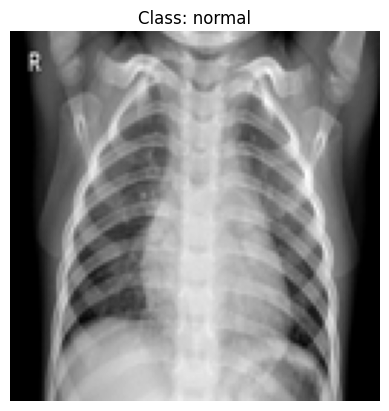

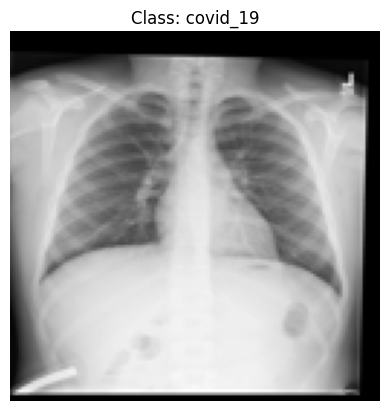

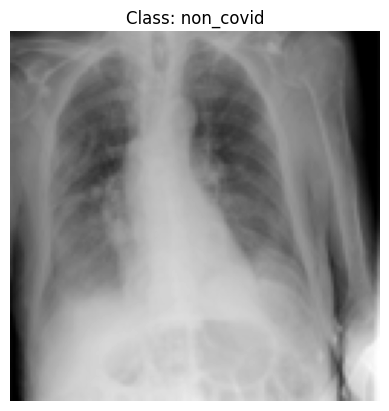

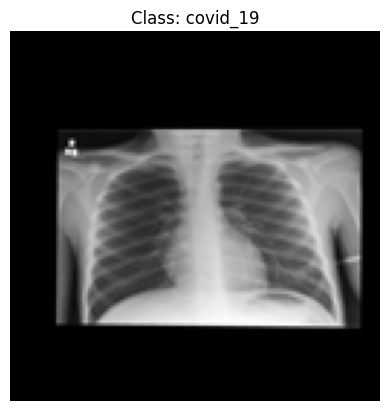

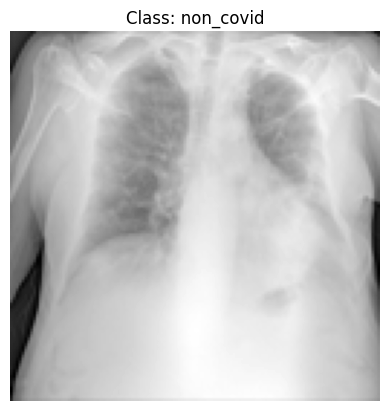

In [18]:
show_image(dataset, classes, 5, unique=False)

## Модель

In [19]:
# Сверточная нейронная сеть
model = nn.Sequential(
    Conv2dBlock(1, 9),
    Conv2dBlock(9, 16),
    SkipConnection(
        Conv2dBlock(16, 16, False)
    ),
    Conv2dBlock(16, 32, False),
    Conv2dBlock(32, 64),
    SkipConnection(
        Conv2dBlock(64, 64, False)
    ),
    Conv2dBlock(64, 96),
    nn.Flatten(),
    LinearBlock(6144, 3500, 0.15),
    LinearBlock(3500, 2000, 0.1),
    LinearBlock(2000, 1000, 0.1),
    LinearBlock(1000, 500),
    LinearBlock(500, len(classes))
)

### Summary

In [20]:
input_size = (1, *size)
summary(model.cuda(), input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 1, 128, 128]               2
            Conv2d-2          [-1, 9, 128, 128]              90
              ReLU-3          [-1, 9, 128, 128]               0
         MaxPool2d-4            [-1, 9, 64, 64]               0
       Conv2dBlock-5            [-1, 9, 64, 64]               0
       BatchNorm2d-6            [-1, 9, 64, 64]              18
            Conv2d-7           [-1, 16, 64, 64]           1,312
              ReLU-8           [-1, 16, 64, 64]               0
         MaxPool2d-9           [-1, 16, 32, 32]               0
      Conv2dBlock-10           [-1, 16, 32, 32]               0
      BatchNorm2d-11           [-1, 16, 32, 32]              32
           Conv2d-12           [-1, 16, 32, 32]           2,320
             ReLU-13           [-1, 16, 32, 32]               0
      Conv2dBlock-14           [-1, 16,

## Оптимизатор и функция активации

In [21]:
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
loss_fn = nn.CrossEntropyLoss()

## Обучение

Epoch: 15
Accuracy: 0.9902


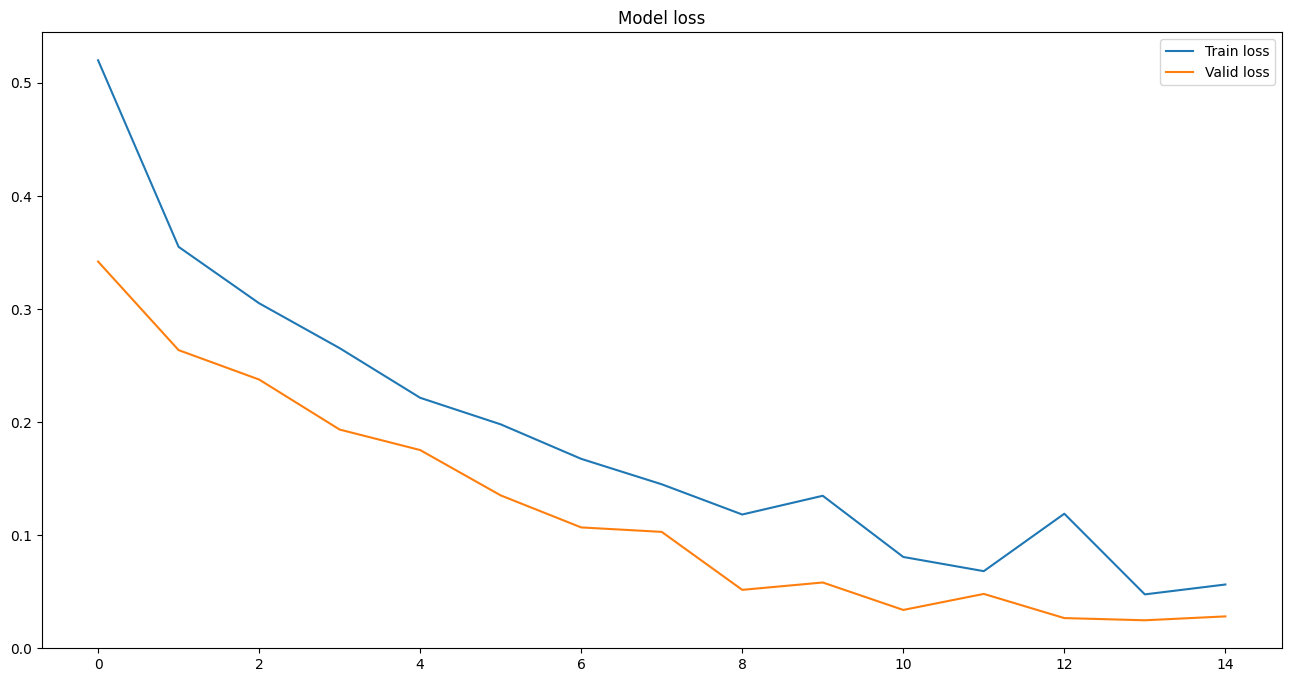

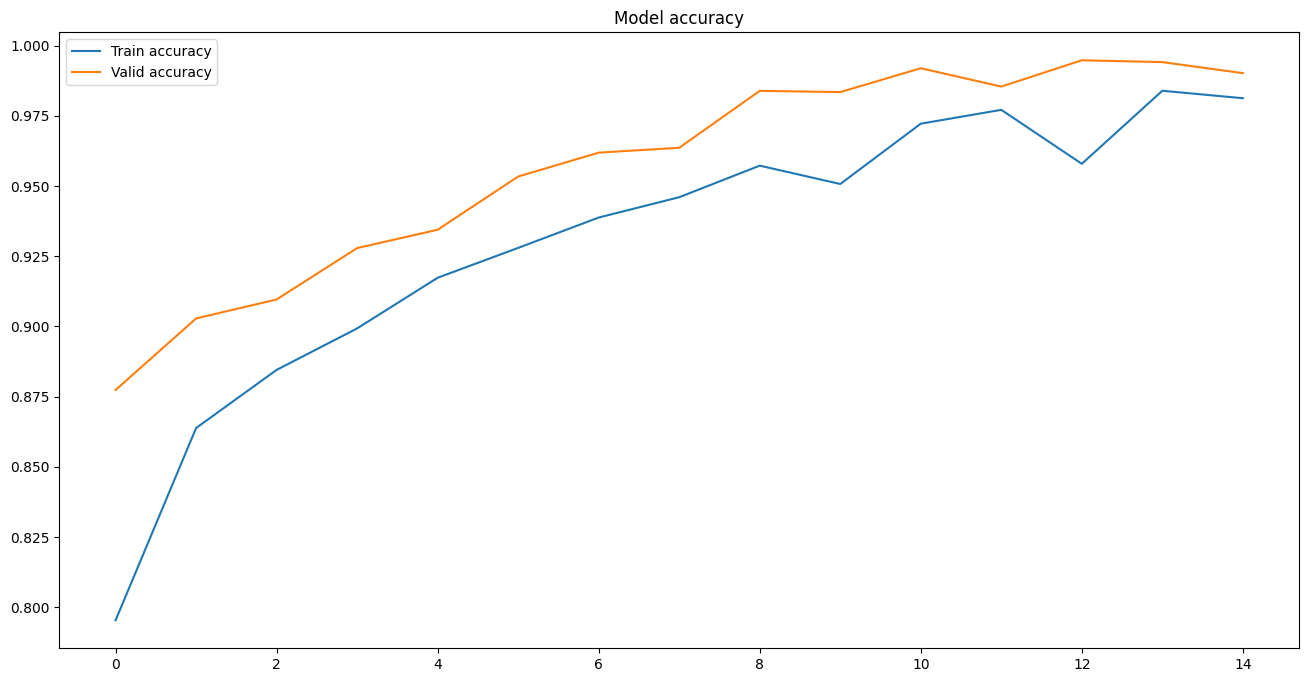

In [22]:
best_model, best_accuracy = fit(model, trainloader, validloader, optimizer, loss_fn, 15)

## Тестирование

In [27]:
y_true = [x[1] for x in testset]
y_pred = predict(best_model, testset)

print(f"f1_score: {f1_score(y_true, y_pred, average='macro'):.4f}")

f1_score: 0.9003


## Submit

In [24]:
path = 'test_images'
data = list() # список необработанных данных

for i, image_name in enumerate(tqdm(sorted(os.listdir(path), key=lambda x: int(x[4:-4])))):
    image_numpy = Image.open(f'{path}/{image_name}').resize(size)
    data.append(transform(image_numpy))

100%|██████████| 6920/6920 [00:10<00:00, 642.34it/s]


In [25]:
submit = predict(best_model, data)

In [26]:
submit = pd.DataFrame(submit, columns=['target_feature'])
submit.index.name = 'id'
submit.to_csv('submit.csv')